In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/Users/atharhussain/Developer/Projects/ML/NASA/data/clean_data.csv')
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous,diameter_mean,velocity_diameter_ratio,log_miss_distance,threat_score
0,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False,0.220568,1.127334e+05,18.023286,3.281926e-09
1,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False,0.321768,2.451763e+05,17.229836,1.058571e-08
2,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False,0.124035,4.517780e+05,17.960526,1.965102e-09
3,3656926,(2014 BT8),25.00,0.026580,0.059435,Earth,47477.649832,4.290521e+07,False,0.043007,1.103917e+06,17.574504,1.002380e-09
4,3421513,(2008 OX1),21.50,0.133216,0.297879,Earth,57853.295346,2.727908e+07,True,0.215547,2.684006e+05,17.121631,7.901561e-09


In [4]:
print(df['is_hazardous'].value_counts())

is_hazardous
False    258516
True      30214
Name: count, dtype: int64


In [5]:
X = df.drop(columns=['is_hazardous', 'miss_distance'])
y = df['is_hazardous']

In [6]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Drop useless columns
X = df.drop(columns=['neo_id', 'name', 'is_hazardous'])  
y = df['is_hazardous']

# Encode categorical column(s)
if 'orbiting_body' in X.columns:
    le = LabelEncoder()
    X['orbiting_body'] = le.fit_transform(X['orbiting_body'])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Before SMOTE:", y.value_counts())
print("After SMOTE:", y_resampled.value_counts())


Before SMOTE: is_hazardous
False    258516
True      30214
Name: count, dtype: int64
After SMOTE: is_hazardous
False    258516
True     258516
Name: count, dtype: int64


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(
    n_estimators=300,       
    max_depth=20,           
    min_samples_split=10,  
    min_samples_leaf=5,    
    max_features="sqrt",    
    class_weight="balanced", 
    random_state=42,
    n_jobs=-1
)

RF_model.fit(x_train, y_train)

print("Train Accuracy:", RF_model.score(x_train, y_train) * 100)
print("Test Accuracy:", RF_model.score(x_test, y_test) * 100)


Train Accuracy: 91.2142641281354
Test Accuracy: 90.578007291576


In [9]:
y_pred = RF_model.predict(x_test)

In [10]:
from sklearn.metrics import precision_recall_curve
y_proba = RF_model.predict_proba(x_test)[:,1]
prec, rec, thresh = precision_recall_curve(y_test, y_proba)

# Example: choose threshold where precision and recall are balanced
best_idx = np.argmax(2*prec*rec/(prec+rec))
best_thresh = thresh[best_idx]
print("Best threshold:", best_thresh)

y_pred_custom = (y_proba >= best_thresh).astype(int)

Best threshold: 0.719826780283646


In [11]:
y_proba = RF_model.predict_proba(x_test)[:,1]
best_thresh = 0.719826780283646
y_pred_custom = (y_proba >= best_thresh).astype(int)
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))


Confusion Matrix:
 [[46206  5515]
 [ 2701 48985]]

Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.89      0.92     51721
        True       0.90      0.95      0.92     51686

    accuracy                           0.92    103407
   macro avg       0.92      0.92      0.92    103407
weighted avg       0.92      0.92      0.92    103407



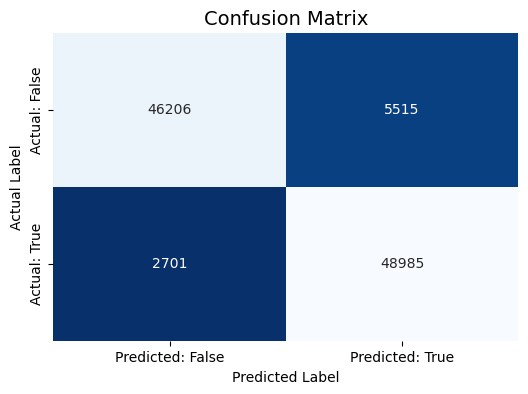

In [12]:
CM = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6, 4))
sns.heatmap(
    CM, 
    annot=True, 
    fmt='d', 
    cmap='Blues_r', 
    cbar=False,
    xticklabels=['Predicted: False', 'Predicted: True'],
    yticklabels=['Actual: False', 'Actual: True']
)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [14]:
joblib.dump(RF_model, "random_forest_asteroid_model.joblib")

print("Model saved as random_forest_asteroid_model.joblib")

Model saved as random_forest_asteroid_model.joblib
